In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#from torch.optim.lr_scheduler import _LRScheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
from torchsummary import summary
import random

# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

#print(os.environ.get('CUDA_VISIBLE_DEVICES'))

/home/MMI24limbyungwan/.conda/envs/byungwan_resn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## RESNET34UNET

In [3]:
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        return x.view_as(x)
    @staticmethod
    def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
        return grad_output * (-1)

class domain_classifier(nn.Module):
    def __init__(self):
        super(domain_classifier, self).__init__()
        self.fc1 = nn.Linear(224*224*64, 10)
        self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정

    def forward(self, x):
        x = x.view(-1, 224*224*64)
        x = GradReverse.apply(x) # gradient reverse
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
        #return torch.sigmoid(x)
        return x

class IdentityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(IdentityBlock, self).__init__()
        
        # 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        
        # 3x3 convolution
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Adding the skip connection
        out += self.skip(identity)
        out = self.relu2(out)
        
        return out


#인코더 블럭
class Conv2(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv2,self).__init__() 
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        p = self.maxpool(x)
        
        return x , p
class Conv3(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv3,self).__init__()         
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,in_channels)
        self.identityblock4 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        x = self.identityblock4(x)
        p = self.maxpool(x)
        
        return x , p
class Conv4(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv4,self).__init__()         
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,in_channels)
        self.identityblock4 = IdentityBlock(in_channels,in_channels)
        self.identityblock5 = IdentityBlock(in_channels,in_channels)
        self.identityblock6 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        x = self.identityblock4(x)
        x = self.identityblock5(x)
        x = self.identityblock6(x)
        p = self.maxpool(x)
        
        return x , p
class Conv5(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv5,self).__init__() 
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,in_channels)
        self.identityblock3 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        x = self.identityblock3(x)
        p = self.maxpool(x)
        
        return x , p
#디코더 블럭
class DecoderBlock(nn.Module):
    def __init__(self, channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1) # output_padding 추가
        self.convblock1 = IdentityBlock(channels*2, channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
            x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
        x = torch.cat([x, skip], dim=1)
        x = self.convblock1(x)
        #print("x",x.shape,"skip: ",skip.shape)
        return x

#Unet구조 middle의 xm값의 움직임에 주의
class Resnet34_Unet(nn.Module):
    def __init__(self,n_classes):
        super(Resnet34_Unet,self).__init__()
        self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.fbn1 = nn.BatchNorm2d(64)
        self.frelu1 = nn.ReLU()
        self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.conv2 = Conv2(64,128)
        self.conv3 = Conv3(128,256)
        self.conv4 = Conv4(256,512)
        self.conv5 = Conv5(512,1024)
        
        self.middleconv = IdentityBlock(1024,2048)
        self.dropout = nn.Dropout2d(0.1) #
           
        self.decoder5 = DecoderBlock(1024)
        self.decoder4 = DecoderBlock(512)
        self.decoder3 = DecoderBlock(256)
        self.decoder2 = DecoderBlock(128)
        self.decoder1 = DecoderBlock(64)
        self.transpose = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1) # output_padding 추가
        
        self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        self.domain_classifier = domain_classifier()
        
    def forward(self,x):
        x = self.fconv1(x)#3->64
        x0 = self.fbn1(x)
        x1 = self.frelu1(x)
        p = self.fmaxpooling(x1)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
        #print("conv1: ",x1.shape, "maxpooling: ",p.shape)
        x2,p = self.conv2(p)
        #print("conv2: ",x2.shape, "maxpooling: ",p.shape)
        x3,p = self.conv3(p)
        #print("conv3: ",x3.shape, "maxpooling: ",p.shape)
        x4,p = self.conv4(p)
        #print("conv4: ",x4.shape, "maxpooling: ",p.shape)
        x5,p = self.conv5(p)
        #print("conv5: ",x5.shape, "maxpooling: ",p.shape)
        
        xm = self.middleconv(p)#xm([8, 4096, 2, 2])
        #print("xm: ",xm.shape, "maxpooling: ",p.shape)
        xm = self.dropout(xm)
        
        x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
        x = self.decoder4(x,x4)#뉴런:1024*2->1024 
        x = self.decoder3(x,x3) #14
        x = self.decoder2(x,x2)#28
        x = self.decoder1(x,x1)#55
        x = self.transpose(x)
        
        #print(x.shape)
        #x = F.interpolate(x, size=(224, 224))
        x_c = self.segmap(x)
        x_d = self.domain_classifier(x)
        
        return x_c

In [41]:
def apply_fisheye_distortion(images, masks, label):
    # 이미지 크기 가져오기
    batch, channel, height, width = images.shape

    # 카메라 매트릭스 생성
    focal_length = width / 4
    center_x = width / 2
    center_y = height / 2
    camera_matrix = np.array([[focal_length, 0, center_x],
                              [0, focal_length, center_y],
                              [0, 0, 1]], dtype=np.float32)

    # 왜곡 계수 생성
    dist_coeffs = np.array([0, 0.02 * label, 0, 0], dtype=np.float32)

    # 왜곡 보정
    undistorted_images = []
    undistorted_masks = []

    for i in range(batch):
        image = images[i].permute(1, 2, 0).cpu().numpy()  # 텐서를 NumPy 배열로 변환
        mask = masks[i].cpu().numpy()
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)
        undistorted_mask = cv2.undistort(mask, camera_matrix, dist_coeffs)
        undistorted_mask = np.round(undistorted_mask).astype(np.uint8)
        undistorted_mask[undistorted_mask > 12] = 12

        # 다시 텐서로 변환
        undistorted_image = torch.from_numpy(undistorted_image).permute(2, 0, 1).float().to(device)
        undistorted_mask = torch.from_numpy(undistorted_mask).long().to(device)

        undistorted_images.append(undistorted_image)
        undistorted_masks.append(undistorted_mask)

    undistorted_images = torch.stack(undistorted_images, dim=0)
    undistorted_masks = torch.stack(undistorted_masks, dim=0)

    return undistorted_images, undistorted_masks

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        directory_path = "/mnt/nas27/Dataset/Samsung_DM"
        #directory_path = './data/224'
        img_path = self.data.iloc[idx, 1]
        img_path = os.path.join(directory_path, img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask_path = os.path.join(directory_path, mask_path)
        mask = cv2.imread(mask_path)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.round(mask).astype(np.uint8)
        mask[mask > 12] = 12 #배경을 픽셀값 12로 간주
        mask += 1
        mask[mask == 13] = 0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

transform = A.Compose(
    [   
     A.Resize(224, 224),
        ToTensorV2()
    ]
)

Original Image Min: 0.0, Max: 255.0


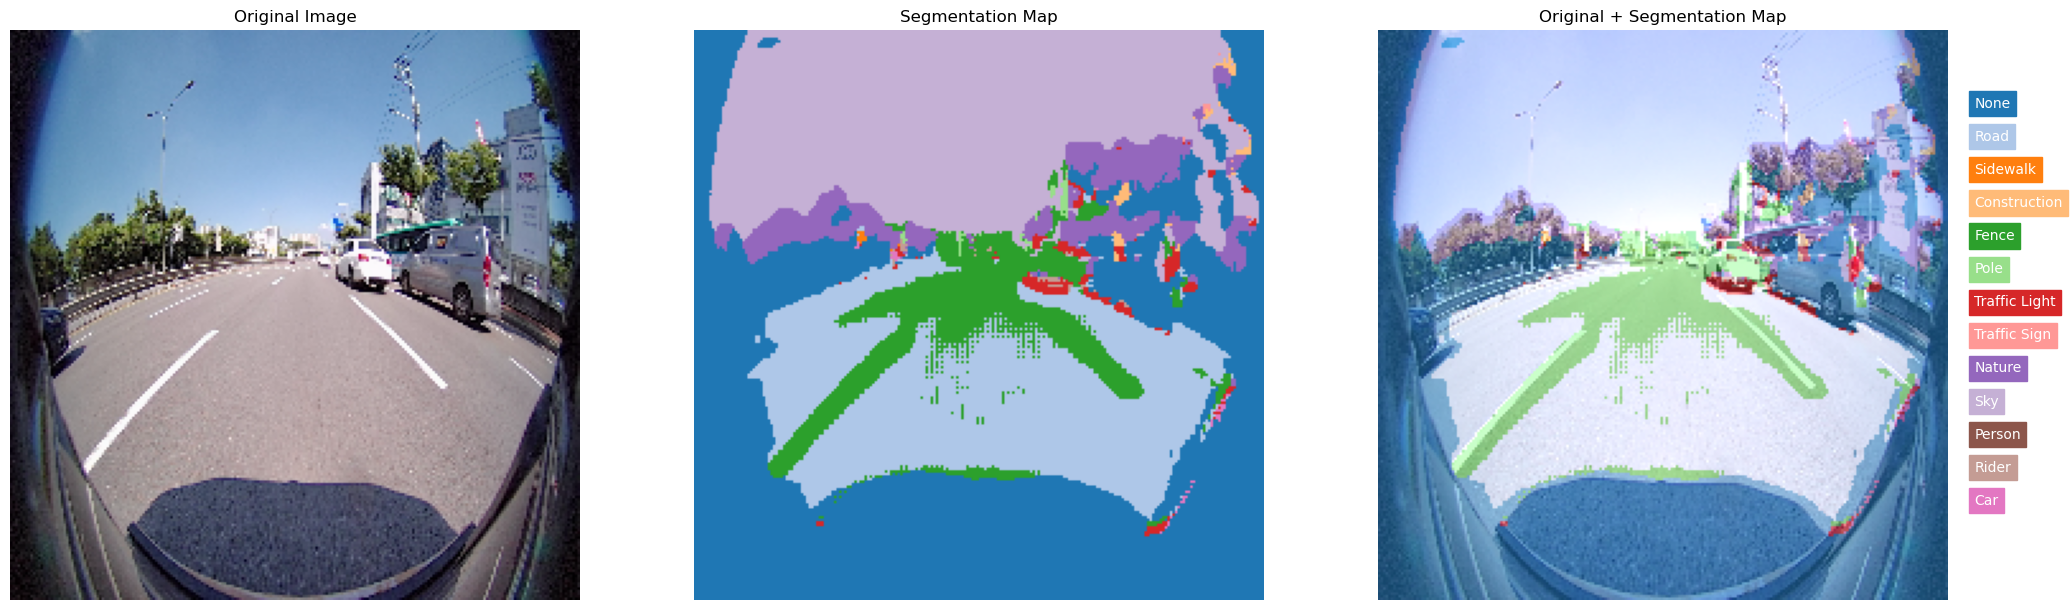

In [114]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from matplotlib.colors import ListedColormap
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import torch
import matplotlib.patches as mpatches

# 원본 데이터 로드
dataset_original = CustomDataset('data/896_csv/val_source.csv', transform=transform)
dataloader_original = DataLoader(dataset_original, batch_size=1, shuffle=True)

# 모델 불러오기
model = Resnet34_Unet(n_classes=13).to(device)
model.load_state_dict(torch.load('./data/resnet34_1112_1.pth'), strict=False)

## 데이터 로드
original_data_iter = iter(dataloader_original)

# next 함수에서 반환되는 값은 데이터셋의 __getitem__에서 정의한대로 이미지와 마스크의 튜플입니다.
original, mask = next(original_data_iter)

# 모델을 통과하기 전에 텐서의 데이터 타입을 변경합니다.
original = original.to(torch.float).to(device)

# 모델을 통과
with torch.no_grad():
    original_seg = model(original)

# 세그멘테이션 맵 처리
seg_map = torch.softmax(original_seg[0], dim=0).cpu()
seg_map = torch.argmax(seg_map, dim=0).cpu().numpy()  # 첫 번째 이미지의 세그맵 선택 및 최대 확률 클래스 선택

# 이미지 값의 범위를 확인
print(f"Original Image Min: {original[0].min()}, Max: {original[0].max()}")

# 모델을 통과하기 전에 텐서의 데이터 타입을 변경하고 이미지를 정규화합니다.
original = original.to(torch.float) / 255.0  # 이미지 값을 [0, 1]로 정규화

# 'tab20' colormap 가져오기
tab20_cmap = plt.get_cmap('tab20')

# 13개의 클래스에 해당하는 색상 리스트 생성
num_classes = 13
class_colors = [tuple(int(c * 255) for c in tab20_cmap(i)[:3]) for i in range(num_classes)]

# 세그멘테이션 맵을 컬러로 변환
seg_map_colored = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(class_colors):
    seg_map_colored[seg_map == class_id] = color

# 원본 이미지와 세그멘테이션 맵 나란히 표시
plt.figure(figsize=(25, 8))

# 원본 이미지
plt.subplot(1, 3, 1)
original_image = transforms.ToPILImage()(original[0].cpu())
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# 세그멘테이션 맵
plt.subplot(1, 3, 2)
plt.imshow(seg_map_colored)
plt.title('Segmentation Map')
plt.axis('off')

# 겹쳐진 이미지
plt.subplot(1, 3, 3)
# 원본 이미지와 세그멘테이션 맵을 겹쳐서 표시
original_image_cv2 = np.array(original_image.convert("RGB"))
# seg_map_colored를 uint8로 변환
seg_map_colored_uint8 = seg_map_colored.astype(np.uint8)
# 세그멘테이션 맵 적용
seg_map_colored_alpha = np.zeros_like(original_image_cv2, dtype=np.uint8)

# Iterate through each class and overlay the color on the corresponding pixels
for class_id, color in enumerate(class_colors):
    class_mask = seg_map == class_id
    seg_map_colored_alpha[class_mask] = color

# 이미지 합성
overlay_image_cv2 = cv2.addWeighted(original_image_cv2, 0.7, seg_map_colored_alpha, 0.6, 0)
plt.imshow(overlay_image_cv2)
plt.title('Original + Segmentation Map')
plt.axis('off')


classes = ['None','Road','Sidewalk','Construction','Fence','Pole','Traffic Light','Traffic Sign','Nature','Sky','Person','Rider','Car']
# 각 클래스에 대한 레이블을 오버레이 이미지 오른쪽에 표시
label_interval = 13  # 라벨 간격 조정
for class_id, color in enumerate(class_colors):
    rgba_color = tuple(c / 255.0 for c in color)  # [0, 1] 범위로 변환
    plt.text(original_image_cv2.shape[1] + 10, 30 + class_id * label_interval, f"{classes[class_id]}", color='white', backgroundcolor=rgba_color, ha='left')

plt.show()
